In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data.csv') 

In [4]:
print(data.head())

   temperature   gas  smoke  noise  vibration  fan_status
0     8.727006  3254      0   1661          0           1
1    37.535715   863      0    834          0           0
2    26.599697  2595      0   1462          1           0
3    19.932924  3953      0   1679          0           1
4    -2.199068  3108      0   1719          0           1


In [22]:
plt.figure(figsize=(20, 15)) 

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

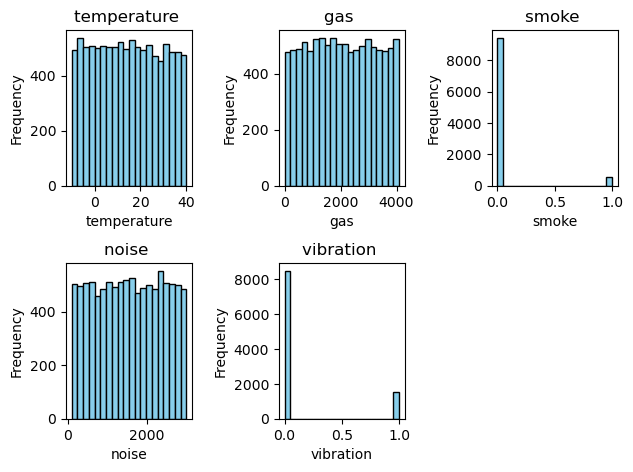

In [29]:
for i, feature in enumerate(feature_columns):
    plt.subplot(2, 3, i + 1)  # Create a grid of subplots (2 rows, 3 columns for up to 6 features)
    plt.hist(data[feature], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'{feature} ', fontsize=12)  # Increased font size for better readability
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout(pad=1.0)  # Add padding between subplots for readability
plt.show()

In [13]:
correlation_matrix = data.corr()

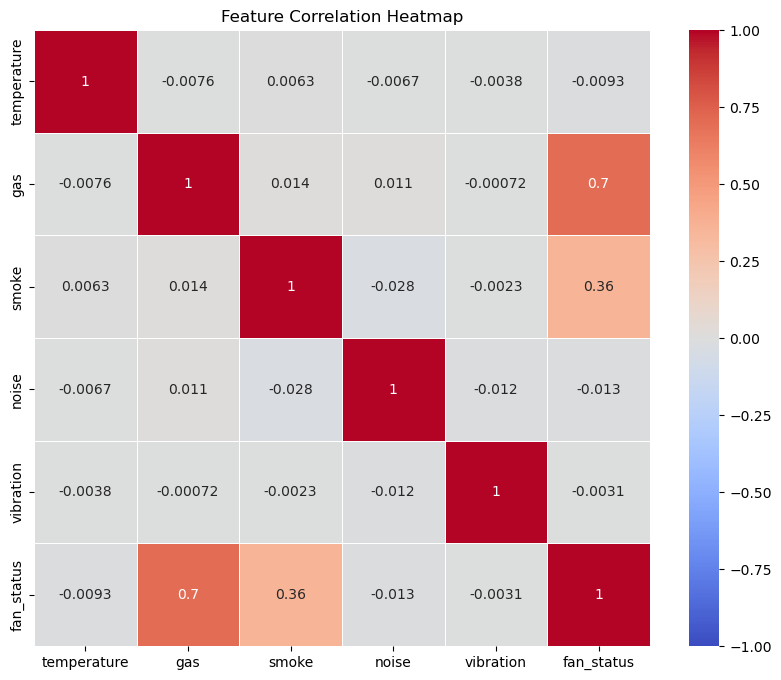

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [30]:
X = data[feature_columns].values
y = data[target_column].values



In [31]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [32]:
# Reshape the data for LSTM (samples, timesteps, features)
timesteps = 10  # Use last 10 readings for prediction
X_reshaped = []
y_reshaped = []

for i in range(timesteps, len(X_scaled)):
    X_reshaped.append(X_scaled[i-timesteps:i])
    y_reshaped.append(y[i])

X_reshaped, y_reshaped = np.array(X_reshaped), np.array(y_reshaped)



In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)



In [34]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])



f:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)



In [39]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7021 - loss: 0.6244 - val_accuracy: 0.6929 - val_loss: 0.6168
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7032 - loss: 0.6087 - val_accuracy: 0.6929 - val_loss: 0.6172
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6970 - loss: 0.6151 - val_accuracy: 0.6929 - val_loss: 0.6167
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7040 - loss: 0.6089 - val_accuracy: 0.6929 - val_loss: 0.6165
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7022 - loss: 0.6109 - val_accuracy: 0.6929 - val_loss: 0.6181
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7075 - loss: 0.6031 - val_accuracy: 0.6929 - val_loss: 0.6174
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6986 - loss: 0.6124 - val_accuracy: 0.6929 - val_loss: 0.6175
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7010 - loss: 0.6102 - val_accuracy: 0.

In [40]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.6252
Test Loss: 0.6350, Test Accuracy: 0.6737


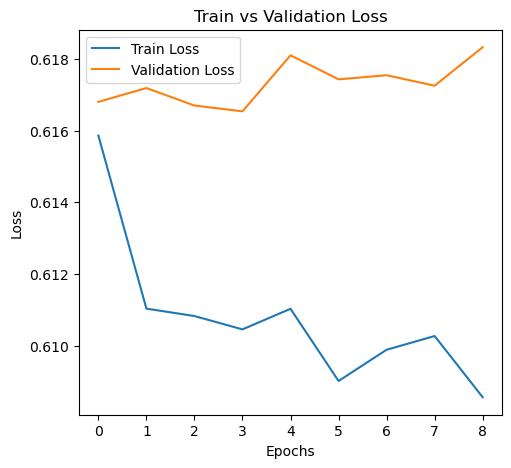

In [41]:
# 1. Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


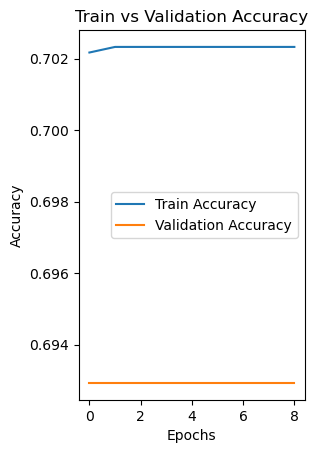

In [42]:
# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
# 2. Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6836 - loss: 0.6252
Test Loss: 0.6350, Test Accuracy: 0.6737


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


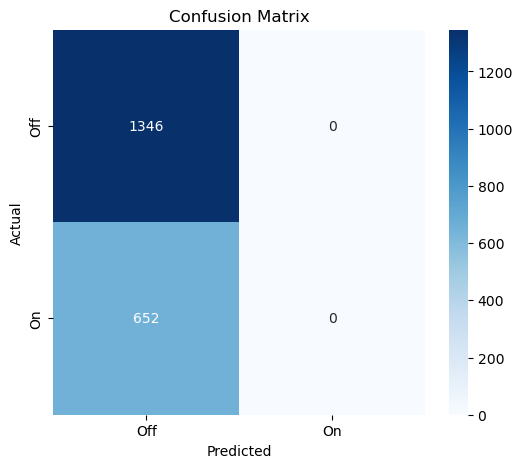

In [46]:
# 3. Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype('int32')  # Predict probabilities and convert to binary (0 or 1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Off', 'On'], yticklabels=['Off', 'On'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.81      1346
           1       0.00      0.00      0.00       652

    accuracy                           0.67      1998
   macro avg       0.34      0.50      0.40      1998
weighted avg       0.45      0.67      0.54      1998



f:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
# 5. ROC-AUC Score
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC-AUC Score: 0.4853


## RF

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
data = pd.read_csv('data.csv') 
feature_columns = ['temperature', 'gas', 'smoke', 'noise', 'vibration']  # adjust as needed
target_column = 'fan_status'  # The column you want to predict (0 for off, 1 for on)A

In [29]:
print(data.head())

   temperature   gas  smoke  noise  vibration  fan_status
0     8.727006  3254      0   1661          0           1
1    37.535715   863      0    834          0           0
2    26.599697  2595      0   1462          1           0
3    19.932924  3953      0   1679          0           1
4    -2.199068  3108      0   1719          0           1


In [30]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  10000 non-null  float64
 1   gas          10000 non-null  int64  
 2   smoke        10000 non-null  int64  
 3   noise        10000 non-null  int64  
 4   vibration    10000 non-null  int64  
 5   fan_status   10000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 468.9 KB
None


In [6]:
X = data[feature_columns].values
y = data[target_column].values



In [7]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [10]:
# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)



In [16]:
rf_model = RandomForestClassifier(
    n_estimators=200,       # More trees
    max_depth=10,           # Limit tree depth
    min_samples_split=5,    # Minimum samples to split
    min_samples_leaf=4,     # Minimum samples at leaf node
    max_features='sqrt',    # Use sqrt of total features for each split
    criterion='entropy',    # Use entropy for split quality
    bootstrap=False,        # Don't use bootstrap sampling
    class_weight='balanced', # Handle class imbalance
    random_state=42
)


In [18]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [19]:
# 1. Evaluate the model on the test set
y_pred = rf_model.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")



Test Accuracy: 1.0000


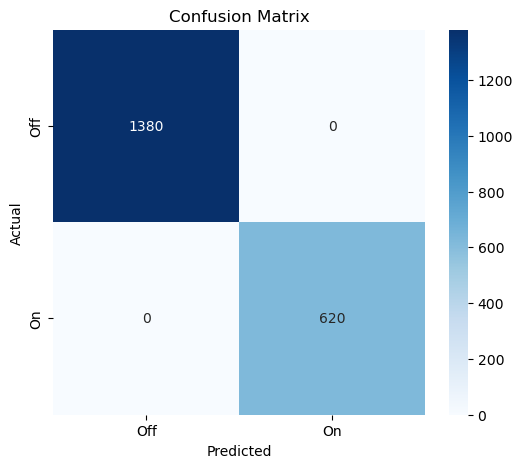

In [20]:
# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Off', 'On'], yticklabels=['Off', 'On'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [14]:
# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1380
           1       1.00      1.00      1.00       620

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [15]:
# 4. ROC-AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])  # Get probabilities for class 1
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 1.0000


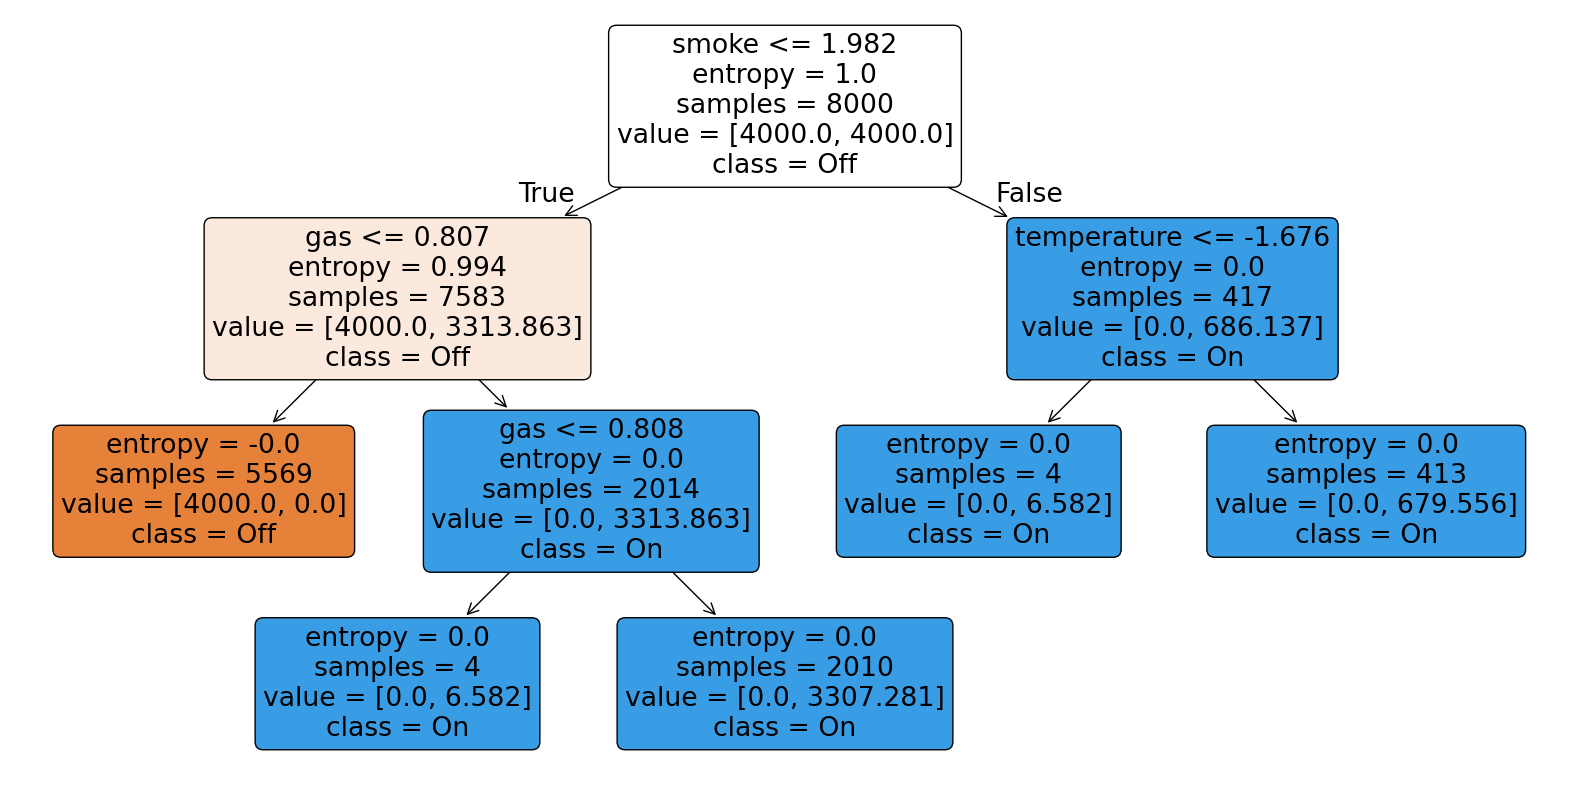

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizing the first tree in the Random Forest
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], filled=True, feature_names=feature_columns, class_names=['Off', 'On'], rounded=True)
plt.show()


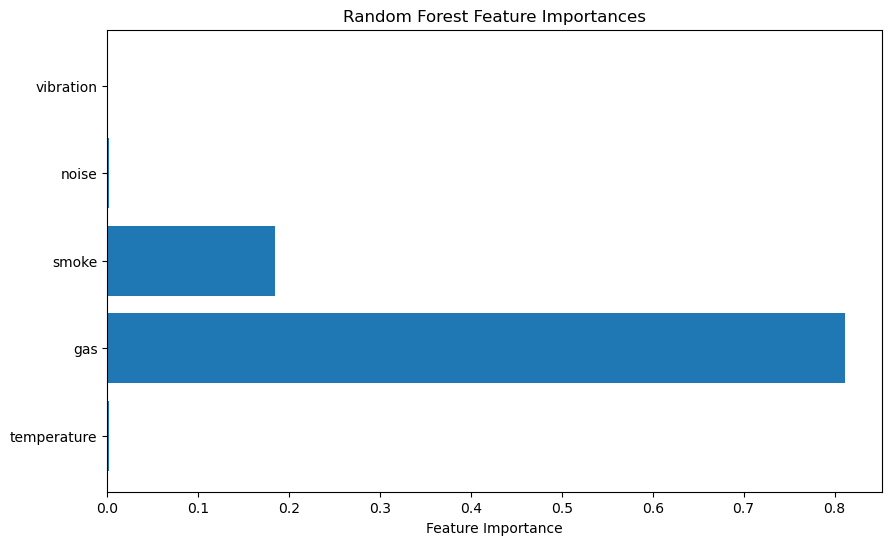

In [22]:
feature_importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


In [27]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, feature_names=feature_columns)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [24]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(rf_model, X_train, features=[0, 1], feature_names=feature_columns, target=1)
plt.show()


ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (f:\Anaconda\Lib\site-packages\sklearn\inspection\__init__.py)

In [ ]:
# Save the trained model and the scaler
model.save('fan_status_model.h5')
with open('scaler.pkl', 'wb') as f:
    import pickle
    pickle.dump(scaler, f)

print("Model and scaler saved.")